In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import bluesquare_data_pipelines.access as blsq

%matplotlib inline

/anaconda3/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [171]:
%%capture
pdss = blsq.dhis_instance("local_pdss")

pdss_elements = ["Consultation Externe (nvx cas patient indigent) - plafond 5%", "Enfant complètement vacciné", 
                "SP3/TPI3 : Troisième dose du Sulfadoxine Pyriméthamine chez la femme enceinte", "Consultation Prénatale 1ère visite",
                "Consultation Prénatale 4ème visite",
                "Accouchement assisté", "Consultation Postnatale", "PF: Acceptantes nouvelles et renouvellment (oral & inj)",
                "Surveillance de la croissance des enfants de 0 à 11 mois", "PF: Acceptantes nouvelles et renouvellment (DIU et implant)",
                "Surveillance de la croissance enfants de 12 à 59 mois", "Femme enceinte VIH+ mise sous protocole ARV prophylaxie",
                "Prise en charge du nouveau-né d'une femme VIH+"]

pdss_ids = pdss.dataelement.uid[pdss.dataelement.name.str.contains('|'.join(pdss_elements))]

In [172]:
%%capture
pdss_extract = pdss.get_data(pdss_ids, pdss.organisationunit.uid) ;

In [110]:
pdss_extract.dataelementname = pdss_extract.dataelementname.str.lower()
pdss_extract = pdss_extract[(pdss_extract.monthly < "201901") & (pdss_extract.monthly >= "201701")]

In [117]:
pdss_extract = pdss_extract.set_index(["uidlevel2", "uidlevel3","uidorgunit","monthly"])
pdss_extract.value = pdss_extract.value.astype(float).astype(int)

pdss_verified = pdss_extract[pdss_extract.dataelementname.str.contains("- ver")]

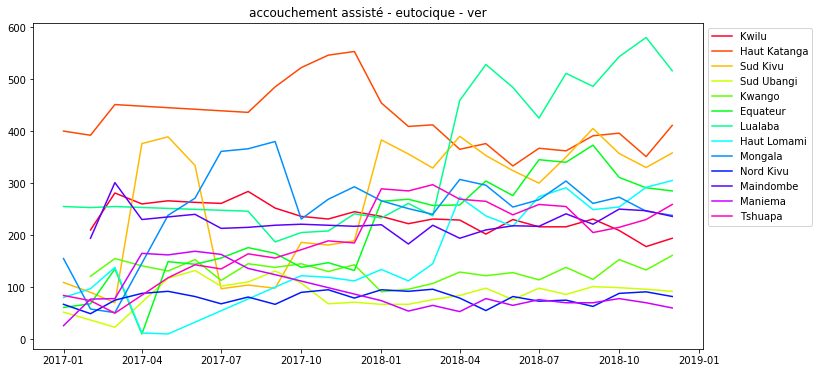

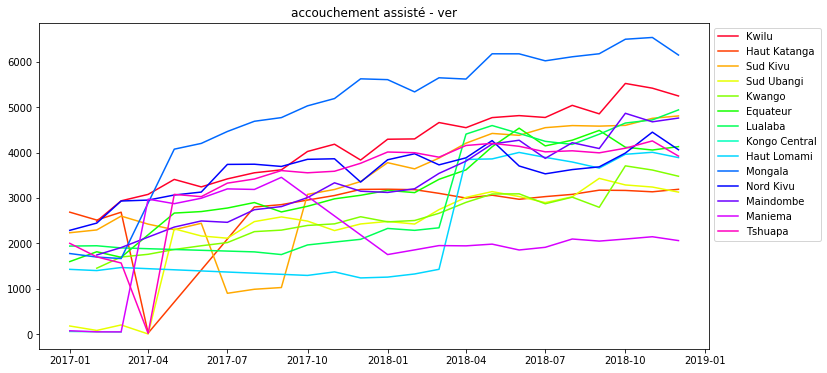

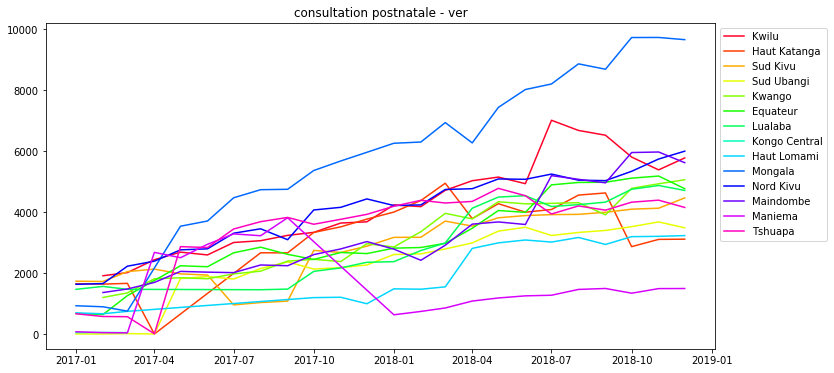

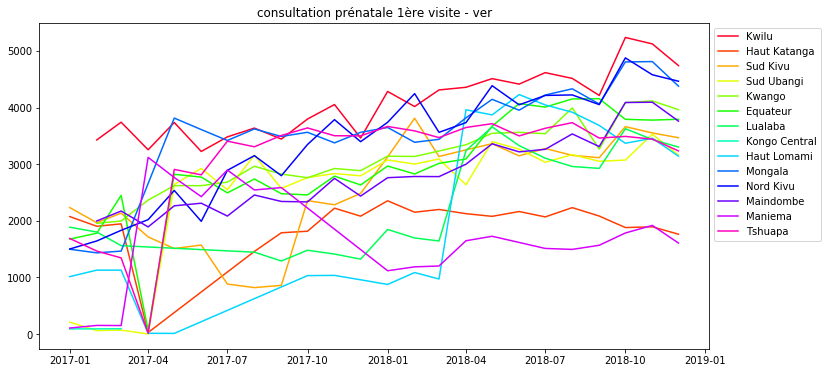

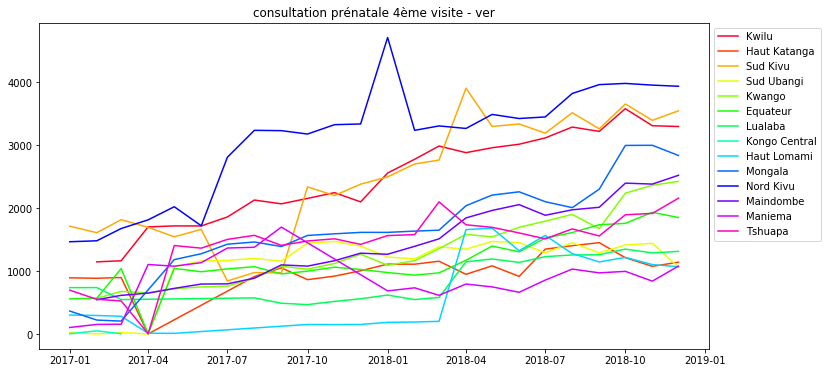

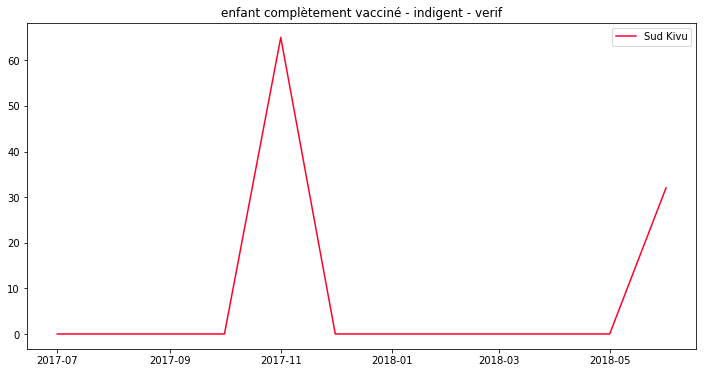

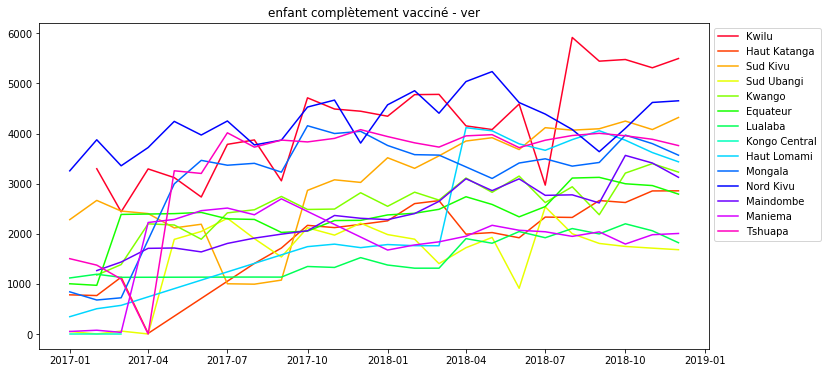

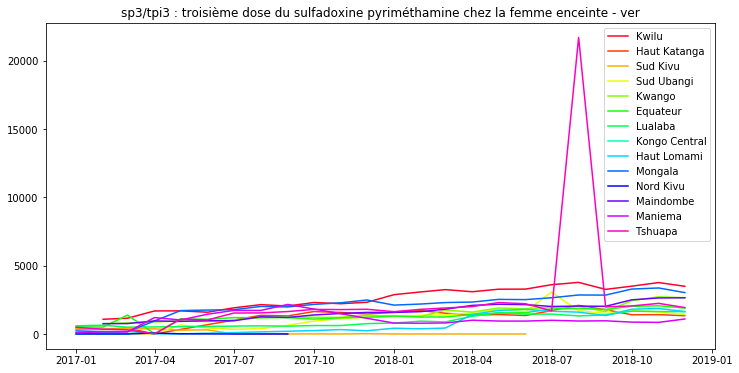

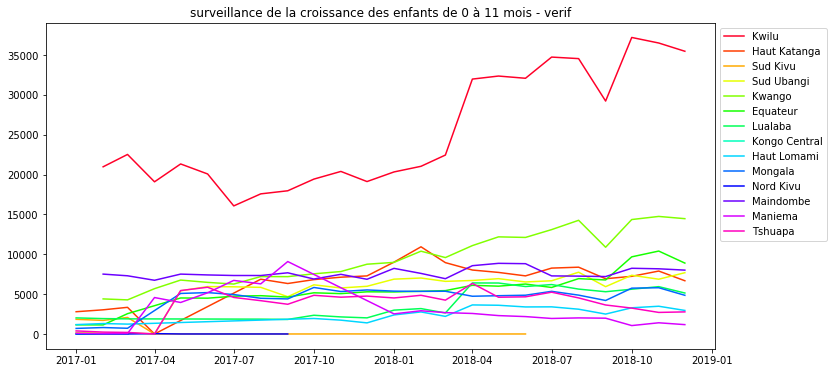

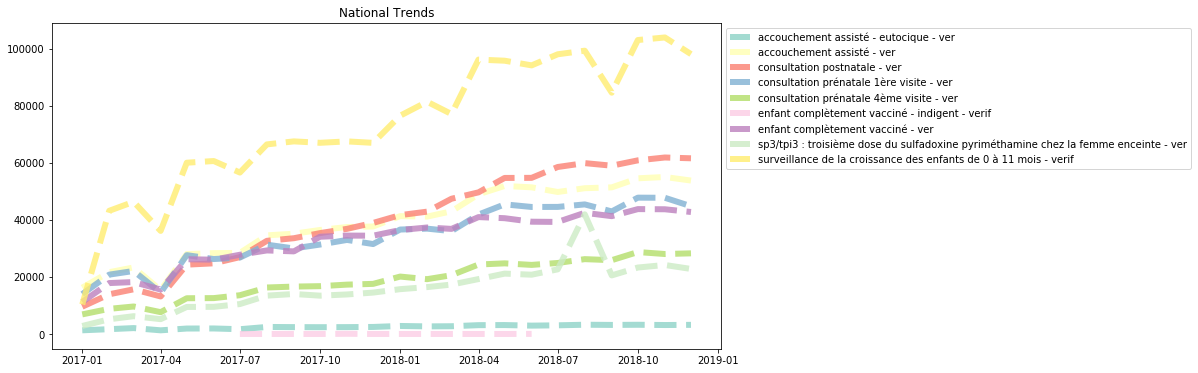

In [168]:
nat_graph = {}
for serie in sorted(pdss_verified.dataelementname.unique()):
    plot_d = pdss_extract[pdss_extract.dataelementname == serie].groupby(level=[0,3]).value.apply(sum).reset_index()
    plot_d = plot_d.merge(pdss.organisationunit[["uid","name"]], left_on ="uidlevel2" , right_on = "uid")
    cmap = plt.cm.gist_rainbow(np.linspace(0, 1, plot_d.name.nunique()))
    fig1 = plt.figure(figsize = [12,6])
    plot_d.monthly = pd.to_datetime(plot_d.monthly.astype(str),  format='%Y%m')
    i = 0
    for zone in plot_d.name.unique():
        d = plot_d[plot_d.name == zone]
        plt.plot(d.monthly, d.value, "-", label=zone.strip()[3:-4], c = cmap[i])
        i = i+1
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title(serie)
    plot_nat = pdss_extract[pdss_extract.dataelementname == serie].groupby(level=3).value.apply(sum).reset_index()
    plot_nat.monthly = pd.to_datetime(plot_nat.monthly.astype(str),  format='%Y%m')
    nat_graph[serie] = plot_nat

fig1 = plt.figure(figsize = [12,6])
cmap = plt.cm.Set3(np.linspace(0, 1,  len(nat_graph.keys())))
i = 0
for serie in nat_graph.keys():
    plot_nat_graph = nat_graph[serie]
    plt.plot(plot_nat_graph.monthly, plot_nat_graph.value,"--", label = serie, linewidth = 6, alpha = .8, c = cmap[i])
    i = i + 1
    plt.legend(bbox_to_anchor=(1, 1)) 
    plt.title("National Trends")